# train LG model on imbalanced ClinVar with 29 features

Method:
1. hyperparameter C tuning, 
2. coefficient of logistic regression model, 
3. Decision boundary plot, 
5. SKlearn pipeline and preprocessing, cross-validation, grid search, save model and preprocessor




In [13]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt

## data preprocessing

cleaned ClinVar data with target variable

In [15]:
df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)
df

/var/folders/q0/2p8kfxsn7s73349btf1_g07h0000gp/T/ipykernel_64250/3969921985.py:1: DtypeWarning: Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)


,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-30.0,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.0,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,41.0,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.0,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-35.0,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,25.0,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG','CADD', 'AF_TGP', 'Frq', 'IMPACT','GNOMADAF_popmax', 'Hom', 'ORIGIN',
       'SPIDEX', 'SWEGENAF', 'Consequence', 'BIOTYPE', 'SIFT',
       'PolyPhen', 'MES-SWA_acceptor_alt', 'MES-SWA_acceptor_diff',
       'MES-SWA_donor_alt', 'MES-SWA_donor_diff', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df[featureV1]



""" 2. only remove missing target 
instead of other variables, since different input file may have different missing situation  """

drop_nan_features = ['CLNSIG']
df_1 = df_1.dropna(subset=drop_nan_features)

In [17]:
""" 3. deal with target feature """
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# df_1["CLNSIG"].unique()

In [18]:
"""4.2  keep imbalance classes """

# split
from sklearn.model_selection import train_test_split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)

In [19]:
""" 5. features engineering: transformer"""
## only for training data, no care about target 'CLNSIG', total 29 features

from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

## numerical feature group 1 : replace missing with mean;  scaling/standardization

numeric_feature_1 = ['MES-SWA_acceptor_alt','MES-SWA_acceptor_diff','MES-SWA_donor_alt','MES-SWA_donor_diff','MaxEntScan_alt','MaxEntScan_diff','GERP++_RS',
    'phastCons100way_vertebrate','phyloP100way_vertebrate']



## numerical feature group 2 : replace missing with 0;  scaling/standardization
numeric_feature_2 = ['CADD','AF_TGP', 'Frq', 'GNOMADAF_popmax', 'Hom',
       'SWEGENAF','LoFtool','pLI_gene_value','SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG','SpliceAI_pred_DS_DL']



## numerical feature group 3: add missing indicator; replace missing with 0 and ; scaling/standardization
numeric_feature_3 = ['SPIDEX','REVEL_score','SpliceAI_pred_DS_AG']



## categorical ordinal feature group 4: add missing indicator for ['SIFT','PolyPhen']; replace missing with 'missing_value' string; OrdinalEncoder
categori_oridinal_feature_4 =['Consequence','IMPACT','SIFT','PolyPhen']

# ordinal features' order: left to right will be from 0 to length-1
with open('variant_consequences.txt','r') as f:             # get the 'variant_consequences order' lst: descending severity
    order_conseq=[line.rstrip("\n") for line in f] 
    order_conseq.reverse()

ordinal_features = [
    'Consequence',
    'IMPACT',
    'SIFT',
    'PolyPhen']
# 0 is the missing value will be replaced by
ordinal_ordering = [
    order_conseq,
    ['MODIFIER','LOW','MODERATE','HIGH'],
    ['tolerated_low_confidence','tolerated','deleterious_low_confidence','deleterious'],
    ['unknown','benign','possibly_damaging','probably_damaging']
    ]


## categorical nominal feature group 5: replace missing with 0 in ['ORIGIN'], with ''missing_value' in ['BIOTYPE'];  BinaryEncoder
categori_nominal_feature_5 = ['ORIGIN','BIOTYPE']  #,'BIOTYPE'



numeric_feature_1_transformer =make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

numeric_feature_2_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

numeric_feature_3_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

categori_oridinal_feature_4_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  # If None, fill_value will be 0 when imputing numerical data and “missing_value” for strings
    OrdinalEncoder(categories=ordinal_ordering, handle_unknown='use_encoded_value', unknown_value = -1)       # the unknown 'missing_value' string will be enocoded as '-1'
)

categori_oridinal_feature_5_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  
    BinaryEncoder()                                # add new columns, throw the original columns automaticly, 
)


preprocessor = make_column_transformer(
    (numeric_feature_1_transformer, numeric_feature_1),
    (numeric_feature_2_transformer, numeric_feature_2 ),
    (MissingIndicator(), numeric_feature_3 + categori_oridinal_feature_4[2:]),   # add new missing indicators for feature3 + ['SIFT','PolyPhen'] without originial columns,  here: total add 5 indicator columns
    (numeric_feature_3_transformer, numeric_feature_3),  
    (categori_oridinal_feature_4_transformer, categori_oridinal_feature_4),
    (categori_oridinal_feature_5_transformer, categori_nominal_feature_5),                                                    
    # (categori_oridinal_feature_5_transformer, categori_nominal_feature_5[1:])   # for checking: how many ori and biotype derived features seperately; must use [1:] formate, and see the `'BIOTYPE` first, and then can get `origin`
    # remainder='passthrough'                                                   # so here for `BIOTYPE` derived new: 5   ,  `Origin` new: 6 
)

## total features after preprocessor: 43


### check the columns names after preprocessor steps

In [8]:
## way to call preprocessor : https://ubc-cs.github.io/cpsc330/lectures/06_column-transformer-text-feats.html#identify-the-transformations-we-want-to-apply

# preprocessed_features_X = preprocessor.fit_transform(X_train, y_train)
preprocessed_features_X = preprocessor.fit_transform(X_train)             # preprocessor only perform on X_train, and didn't do anything on y_train, so this two command output are same, just get 43 features in X_train

In [9]:
pd.DataFrame(preprocessed_features_X)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-0.961258,-2.573888,0.150759,-0.826987,-5.572638e-16,0.0,1.975482e+00,1.299722e+00,2.054832e+00,1.628250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.913559,0.139454,-0.835431,-1.437290,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,-0.142574,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.777132,-0.080785,-0.209874,0.374348,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,-0.789858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.886172,-3.009785,0.253526,1.118929,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,-1.022955,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.016484,1.073267,0.208254,-0.109466,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,1.150801,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553591,0.348565,0.885447,0.233214,0.316126,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,0.415871,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
553592,-0.396122,0.170112,0.256969,-0.625876,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,-0.141721,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
553593,-0.624462,0.796295,1.323376,-0.593280,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,-1.044526,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
553594,-0.767559,-0.076556,-0.825447,1.485685,-5.572638e-16,0.0,3.378841e-16,-6.657163e-16,5.981746e-16,0.095298,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
col1 = numeric_feature_1 + numeric_feature_2

In [21]:
col2 = ['miss_SPIDEX', 'miss_REVEL_score', 'miss_SpliceAI_pred_DS_AG', 'miss_SIFT', 'miss_PolyPhen']

In [22]:
col3 = numeric_feature_3 + categori_oridinal_feature_4

In [23]:
len(col1+col2 +col3)

32

In [24]:
col4 = ['ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'BIOTYPE_0','BIOTYPE_1','BIOTYPE_2','BIOTYPE_3','BIOTYPE_4']

In [25]:
cols = col1 + col2 + col3 + col4     ## get all columns's names after preprocessing
len(cols)

43

## train model
now use C = 10, actually from the last step `grid search` in this script.. 

### n-folds cross_validate: by X_train
just have a look for the measure metrics of validation in X_train

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, C=10, random_state= 42)

pipeline = make_pipeline(preprocessor, lr) 


# cross-validation: for measure and give train / validation score : but not build model yet
scores = cross_validate(pipeline, X_train, y_train, return_train_score=True,cv=3)   # cv = 5 defaultly , cross_validate is stratified by default

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,47.770062,0.415802,0.980946,0.981185
1,66.255355,0.402747,0.981597,0.981605
2,56.187429,0.379707,0.981017,0.980914


In [34]:
# calculate the mean and std of validation

def mean_std_cross_val_scores(scores):
    """
    Returns mean and std of cross validation
    """
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}
results["LG"] = mean_std_cross_val_scores(scores)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
LG,56.738 (+/- 9.255),0.399 (+/- 0.018),0.981 (+/- 0.000),0.981 (+/- 0.000)


In [39]:
## get many metrics
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary


lr = LogisticRegression(max_iter=10000, C=10, random_state= 42)   ## increase max_iter here for cross_validate

pipeline = make_pipeline(preprocessor, lr) 



scores = cross_validate(
   pipeline, X_train, y_train, return_train_score=True, scoring=scoring, cv =3
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,47.026284,0.549224,0.980946,0.981185,0.959062,0.959545,0.961525,0.961303,0.956612,0.957793
1,64.522872,0.666668,0.981597,0.981605,0.960409,0.960466,0.961665,0.962681,0.959157,0.958262
2,55.090678,0.591305,0.981017,0.980914,0.959200,0.958968,0.961338,0.960860,0.957070,0.957083


### real test

In [41]:
## fit and real test score
lr = LogisticRegression(max_iter=2000, C=10, random_state= 42)

pipeline = make_pipeline(preprocessor, lr) 
pipeline.fit(X_train, y_train)              # preprocessor and lr both fitted by X_train here!

print(f"accurate on test set: {pipeline.score(X_train, y_train):.4f}")
print(f"accurate on test set: {pipeline.score(X_test, y_test):.4f}")

accurate on test set: 0.9812
accurate on test set: 0.9812


In [38]:
### another way to call pipeline, same to above:  use preprocessor and model separately :


# X_train_proce = preprocessor.fit_transform(X_train)

# lr.fit(X_train_proce,y_train)

# ## preprocessing X_test
# X_test_proce = preprocessor.transform(X_test)

# print("Accuracy on training set: {:f}".format(lr.score(X_train_proce, y_train))) 
# print("Accuracy on test set: {:f}".format(lr.score(X_test_proce, y_test)))

In [42]:
len (lr.coef_[0])

43

In [43]:
## check target
lr.classes_   # LG: Usually it would alphabetically order the target and pick the first one as negative and second one as the positive class. but we already encoder: 0 is benign ;pathogenic is 1

array([0, 1])

## check coeficient , intercept

Feature importances in linear models

In [44]:
print("Model weights: %s" % (lr.coef_))  # these are the learned weights  : coeficient for each features
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term : only one value used in formulation



data = {"features": cols, "coefficients": lr.coef_[0]}    ## 2D list includeing 43 features' coef, get each features's coefficients
df_coef = pd.DataFrame(data)
df_coef

Model weights: [[ 8.02371393e-03  2.72493429e-02  1.09430930e-01  7.48452046e-02
   1.50420869e-01  2.24577897e-01 -1.42689512e-01 -1.52005709e-02
   4.57314835e-02  1.64237325e+00 -1.58997834e+01 -8.07512852e+00
  -9.80922860e+00  1.99964347e+00  3.22557927e+00 -9.92807122e-02
  -1.45454024e-01  1.86967689e-01  2.31995209e-01  5.23774883e-01
   1.08332879e+00  2.57712691e+00  2.03977743e+00 -1.11135388e+00
   1.85328438e+00 -1.27308872e-01  1.25865942e+00  2.58871651e-01
   4.70939057e-02  2.17772334e+00  2.22369650e-01  1.69018289e-03
   4.87142484e+00  1.61465865e+00 -1.02189092e+00  3.18507714e+00
   1.03612427e+00  3.57887547e+00  2.35331418e+00  2.64888464e+00
   1.24635920e+00 -1.18798507e+00 -1.71790985e+00]]
Model intercept: [-16.63497904]


,features,coefficients
0,MES-SWA_acceptor_alt,0.008024
1,MES-SWA_acceptor_diff,0.027249
2,MES-SWA_donor_alt,0.109431
3,MES-SWA_donor_diff,0.074845
4,MaxEntScan_alt,0.150421
5,MaxEntScan_diff,0.224578
6,GERP++_RS,-0.142690
7,phastCons100way_vertebrate,-0.015201
8,phyloP100way_vertebrate,0.045731
9,CADD,1.642373


In [26]:
len(lr.coef_[0])

43

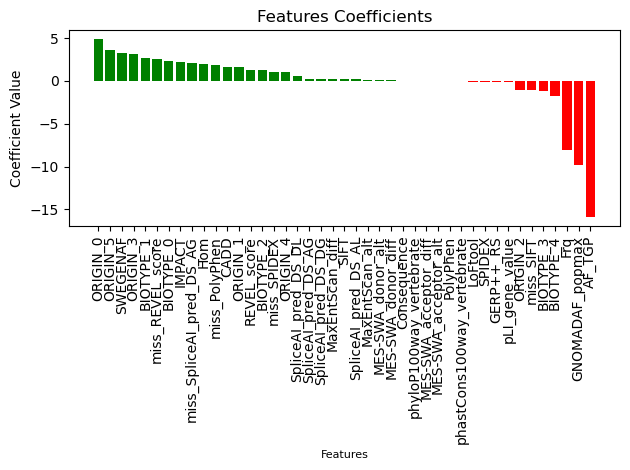

In [45]:
#### barplot of featuress' coefficient: 

# Split the DataFrame into two parts: negative and positive coefficients
df_neg = df_coef[df_coef['coefficients'] < 0].sort_values('coefficients',ascending=False)
df_pos = df_coef[df_coef['coefficients'] >= 0].sort_values('coefficients', ascending=False)

# Concatenate the two parts in reverse order
df_sorted = pd.concat([df_pos, df_neg])

# Set up the plot
fig, ax = plt.subplots()

# Create a bar plot with the coefficients
ax.bar(df_sorted['features'], df_sorted['coefficients'], color=['green' if c >= 0 else 'red' for c in df_sorted['coefficients']])

# Add labels and title
ax.set_xlabel('Features',fontsize=8)
ax.set_ylabel('Coefficient Value')
ax.set_title('Features Coefficients')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
# Adjust the figure size to fit the rotated labels
fig.tight_layout()

# Show the plot
plt.show()

In [46]:
df_neg_1 = df_coef[df_coef['coefficients'] < 0].sort_values('coefficients',ascending=True)
df_neg_1

,features,coefficients
10,AF_TGP,-15.899783
12,GNOMADAF_popmax,-9.809229
11,Frq,-8.075129
42,BIOTYPE_4,-1.717910
41,BIOTYPE_3,-1.187985
23,miss_SIFT,-1.111354
34,ORIGIN_2,-1.021891
16,pLI_gene_value,-0.145454
6,GERP++_RS,-0.142690
25,SPIDEX,-0.127309


In [47]:
df_pos 

,features,coefficients
32,ORIGIN_0,4.871425
37,ORIGIN_5,3.578875
14,SWEGENAF,3.225579
35,ORIGIN_3,3.185077
39,BIOTYPE_1,2.648885
21,miss_REVEL_score,2.577127
38,BIOTYPE_0,2.353314
29,IMPACT,2.177723
22,miss_SpliceAI_pred_DS_AG,2.039777
13,Hom,1.999643


## Decision boundary plot:  have a look for the model boundary

only can be used for 2D features
so use PCA reduce 43 features data to 2D, and  train and fit, and plot:

    PCA can be used to reduce the dimensionality of your data while still retaining much of the important information in the original features. By reducing the dimensionality of your data from 43 features to 2 or 3 principal components, you can create a lower-dimensional representation of your data that still captures most of the variability in the original features.

    However, it's important to keep in mind that when you use PCA to reduce the dimensionality of your data, you are losing some information. The reduced features are not the same as the original features,

In [51]:
# since a lot of features,  we need to PCA reduce features dimensions to 2
from sklearn.decomposition import PCA

# need preprocessd features data
preprocessed_features_X_train = preprocessor.fit_transform(X_train) 
preprocessed_features_X_test = preprocessor.transform(X_test) 

## PCA
pca_fitted = PCA(n_components=2).fit(preprocessed_features_X_train)

X_2d = pca_fitted.transform(preprocessed_features_X_train)
X_T_2d = pca_fitted.transform(preprocessed_features_X_test)


In [52]:
# retrain LG by  PCA reduced data

logreg = LogisticRegression(max_iter=2000, C=10, random_state= 42).fit(X_2d, y_train)   # max iteration to finish converage: max_iter=1000

print("Training set score: {:.3f}".format(logreg.score(X_2d, y_train))) 
print("Test set score: {:.3f}".format(logreg.score(X_T_2d, y_test)))

Training set score: 0.965
Test set score: 0.965


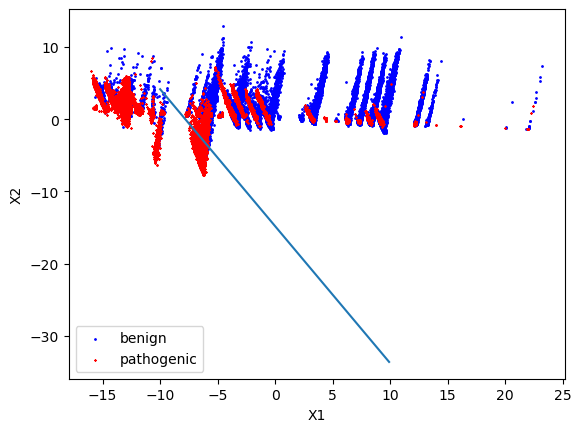

In [53]:
# boundary decision plot: for regression model

coef = np.array(logreg.coef_)
x1_plot = np.arange(-10,10,step=0.1)
x2_plot = -(x1_plot * coef[0][0] + logreg.intercept_)/coef[0][1]
plt.plot(x1_plot, x2_plot)
plt.scatter(X_2d[y_train==0,0],X_2d[y_train==0,1],s=1,c='b',marker='o',label='benign') ##  0
plt.scatter(X_2d[y_train==1,0],X_2d[y_train==1,1],s=1,c='r',marker='x',label='pathogenic') ## 1
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.title('Decision Boundaray')
plt.show()

## Main hyperparameter,  grid search:  might choose C = 10 for now
use validation data, not test data
LG :  C

    smaller C  ---ight lead to underfitting

    bigger C   ---might lead to overfitting

E.g. if I’m massively overfitting, try decreasing max_depth or C.

1. grid search with cross-validation and check accuracy score:  slower, 11 min

In [54]:
## use X_train and  cross_validate to check the accuracy for test:
# for different C, do n folds stratified validation, and look the mean train and validation score

scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),  # train
    "mean_cv_scores": list(),     # validation
}



for C in scores_dict["C"]:
    lr = LogisticRegression(C=C, max_iter=10000, random_state=42)
    pipeline = make_pipeline(preprocessor,lr)

    scores = cross_validate(pipeline, X_train, y_train, return_train_score=True, cv=2)   # cross_validate is used, not only coz it give validation , also it won't created a real model, just give score to measure
                                        ## the pipeline and croo_validation: automatically fitted by X_train and create cross validation part inside
    
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df


,C,mean_train_scores,mean_cv_scores
0,0.0001,0.971476,0.971584
1,0.0010,0.976613,0.976542
2,0.0100,0.978533,0.978549
3,0.1000,0.979987,0.979971
4,1.0000,0.980981,0.980921
5,10.0000,0.981494,0.981346
6,100.0000,0.981600,0.981483
7,1000.0000,0.981618,0.981508
8,10000.0000,0.981636,0.981515
9,100000.0000,0.981613,0.981510


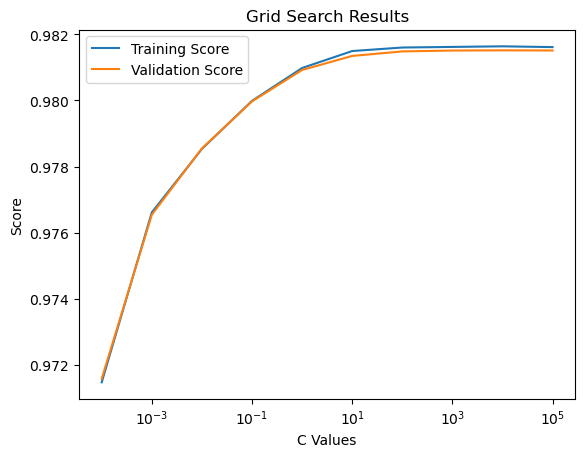

In [55]:
# Create a line semilogx with C values on the x-axis and scores on the y-axis:
### like: C = 10 /100 is best


# Extract the C values, training scores and validation scores from the DataFrame
C_values = results_df['C']
train_scores = results_df['mean_train_scores']
val_scores = results_df['mean_cv_scores']



plt.semilogx(C_values, train_scores, label='Training Score')  # semilogx function uses a logarithmic scale for the X-axis
plt.semilogx(C_values, val_scores, label='Validation Score')
plt.xlabel('C Values')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.legend()
plt.show()

2. since the data classes are imbalance , so draw a ROC-curve instead of only accuracy_score

since save time, didn't do cross_validate here (but results should be same)-- ROC need to use test proba

(maybe also can check `Cross validation with different metrics` , but not yet)

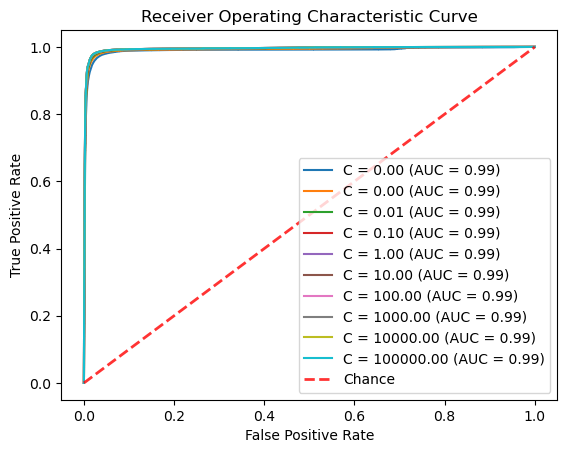

In [56]:

## 9 mins
from sklearn.metrics import roc_curve, auc

scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "train_auc": list(),
}

# create an empty list to store the AUC scores
auc_scores = []

# loop through each C value and generate the ROC with AUC curve
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C, max_iter=10000, random_state = 42)
    pipeline = make_pipeline(preprocessor,lr)
    pipeline.fit(X_train,y_train)


    y_score = pipeline.predict_proba(X_test)[:, 1]  # index 1 -- positive: pathogenic
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label="C = %0.2f (AUC = %0.2f)" % (C, roc_auc))

# plot the ROC curves for all C values in one graph
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


## try  C = 10
LG

1. Precision-recall curve

In [57]:

lr = LogisticRegression(C=10, max_iter=2000, random_state = 42)
pipeline = make_pipeline(preprocessor,lr)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MES-SWA_acceptor_alt',
                                                   'MES-SWA_acceptor_diff',
                                                   'MES-SWA_donor_alt',
                                                   'MES-SWA_donor_diff',
                                                   'MaxEntScan_alt',
                                                   'MaxEntScan_diff',
                                                   'GERP++_RS',
                                                   'phast

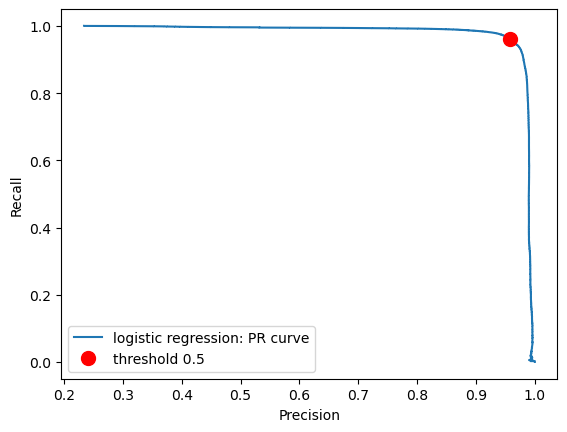

In [58]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


precision, recall, thresholds = precision_recall_curve(
    y_test, pipeline.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipeline.predict(X_test)),
    recall_score(y_test, pipeline.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",   # now by defalt: >= 0.5 patho; < 0.5, benign
)
plt.legend(loc="best")

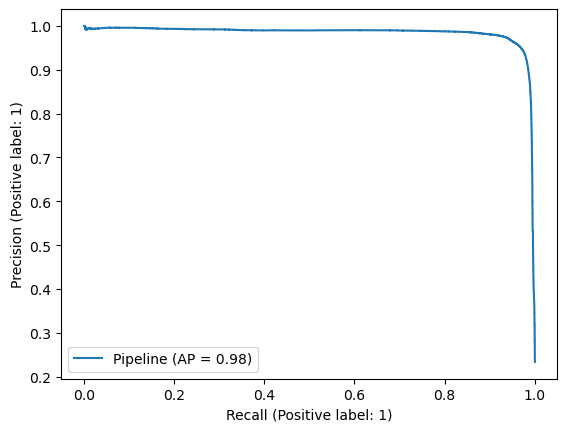

In [59]:
# add AP score to measure the PR curve

from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)